In [ ]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz

--2020-11-05 16:52:31--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  88.8MB/s    in 2.5s    

2020-11-05 16:52:34 (88.8 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
!tar -xvzf flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [1]:
import skimage.io
from skimage.transform import resize
import os
import sys
from skimage.color import rgb2gray
import numpy as np
import cupy as cp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import pickle as pickle
from sklearn.utils import shuffle
from PIL import Image
import os.path
from PIL import ImageOps
from skimage.io import imread, imshow
import copy
from Network import *
from Trainer import *

In [2]:
def readData(file, typ, col):
    root={}
    nroot={}
    for dirpath, label, files in os.walk(file):
        root[dirpath]={}
        files.sort()
        if os.path.exists("/content/flower_photos/LICENSE.txt"):
            os.remove("/content/flower_photos/LICENSE.txt")
        if (typ==1):
            files=files[-100:]
        elif (typ==2):
            files = files[-200:-100]
        else:
            files=files[:len(files)-200]
        for fileName in files:
            if(fileName.split('.')[1]=='jpg'):
                #root[dirpath][fileName]=cv2.imread(dirpath+'/'+fileName)
                root[dirpath][fileName]=imread(dirpath+'/'+fileName, as_gray=col)    #reads images from file into numpy arrays
                root[dirpath][fileName]=resize(root[dirpath][fileName], (32,32))  #resizes the images so that all images in the dataset are comparable
           

    root.pop(file)
    for i in root.keys():
        m=i.split('/')
        j=m[len(m)-1]
        nroot[j]=root[i]
    return nroot

In [3]:
def clean_data(root, labl): #transefers the data into cupy arrays for better performance and reshapes (flattens) each image
  shapes=[]
  X=[]
  Y=[]
  for key,label in root.items():
      for k2,im in label.items():
        X.append(im)
        Y.append(labl[key])
  X=cp.array(X)
  Y=cp.array(Y)
  #X = cp.reshape(X, (X.shape[0], -1))
  X=X-np.mean(X)  #normalizing the data to make it zero centered 
  X=X/np.std(X)  #normalising the STD to make it =1
  return X,Y  

In [4]:
filepath="flower_photos"

mode=0
TrData=readData(filepath, mode, 0)
mode=1
TsData=readData(filepath, mode, 0)
mode=2
VlData = readData(filepath, mode, 0)
c=0
flag= False
for label in TrData.keys():
  if label == '.ipynb_checkpoints': flag=True
if flag: 
  del TrData['.ipynb_checkpoints']
if flag: 
  del VlData['.ipynb_checkpoints']



In [5]:
labels = {}
classes = {}
#create dictionaries for the labels to be accessed and numarized
for label in TrData.keys():  
  labels[label]=c
  classes[c]=label
  c=c+1

In [6]:
print(c)

5


In [7]:
#cleaning training data
X_train, Y_train=clean_data(TrData, labels)
#cleaning testing data
X_test, Y_test = clean_data(TsData, labels)
#cleaning validation data
X_val, Y_val = clean_data(VlData, labels)

In [8]:
X_train[0].shape

(32, 32, 3)

In [9]:
#shuffle the data to ensure a good data distribution per batches if exists
X_train_shuffled , Y_train_shuffled = (X_train,Y_train)
for i in range(10):
    X_train_shuffled , Y_train_shuffled = shuffle(X_train_shuffled,Y_train_shuffled, random_state=0)

data= {}
data['X_train'] = X_train
data['y_train'] = Y_train
data['X_val'] = X_val
data['y_val'] = Y_val
data['X_test'] = X_test
data['y_test'] = Y_test

In [10]:
# the network architicture
prefix='best/'


In [11]:
# create the finetuned model
best_lr = 0.001
best_reg = 0
prefix='best/'

model = Network(network = [
            ConvLayer2D(filter_size=(3,3,3), filters_num=16, lr=best_lr, reg=best_reg, opt='adam' ), 
            ReLU(),
            MaxPoolLayer(pool_size=(2,2)), 
            ConvLayer2D(filter_size=(3,3,16), filters_num=32, lr=best_lr, reg=best_reg, opt='adam' ),
            ReLU(),
            MaxPoolLayer(pool_size=(2,2)), 
            ConvLayer2D(filter_size=(3,3,32), filters_num=64, lr=best_lr, reg=best_reg, opt='adam' ), 
            ReLU(),
            MaxPoolLayer(pool_size=(2,2)), 
            FlattenLayer(),
            Dense(4*4*64, 1024, lr=best_lr, reg=best_reg, prefix=prefix, opt='adam'),
            leakyReLU(),
            Dropout(0.5),
            Dense(1024, 512, lr=best_lr, reg=best_reg, prefix=prefix, opt='adam'),
            leakyReLU(),
            Dropout(0.5),
            Dense(512, 5, lr=best_lr, reg=best_reg, prefix=prefix, opt='adam')
        ])


trainer = Trainer(model,data,batch_size=X_train.shape[0], epochs=250)

trainer.train()
print('Best validation accuracy = %f at epoch: %f'%(trainer.best_val, trainer.best_epoch+1))
print(model.best_val)

poch 47 / 250) train_loss: 1.123637; train acc: 0.510861; val_loss:1.197648; val_acc: 0.478000
(Epoch 48 / 250) train_loss: 1.129590; train acc: 0.527341; val_loss:1.198750; val_acc: 0.490000
(Epoch 49 / 250) train_loss: 1.128949; train acc: 0.523596; val_loss:1.116491; val_acc: 0.548000
(Epoch 50 / 250) train_loss: 1.119572; train acc: 0.537079; val_loss:1.124062; val_acc: 0.542000
(Epoch 51 / 250) train_loss: 1.096313; train acc: 0.530337; val_loss:1.194192; val_acc: 0.478000
(Epoch 52 / 250) train_loss: 1.113213; train acc: 0.515356; val_loss:1.162236; val_acc: 0.514000
(Epoch 53 / 250) train_loss: 1.127542; train acc: 0.554307; val_loss:1.103567; val_acc: 0.548000
(Epoch 54 / 250) train_loss: 1.084909; train acc: 0.527341; val_loss:1.202972; val_acc: 0.500000
(Epoch 55 / 250) train_loss: 1.137387; train acc: 0.547940; val_loss:1.118214; val_acc: 0.530000
(Epoch 56 / 250) train_loss: 1.078018; train acc: 0.541948; val_loss:1.155456; val_acc: 0.534000
(Epoch 57 / 250) train_loss: 1.1

In [12]:
correct = cp.sum(model.fit(X_test)==Y_test)
acc = correct/500
print("Overall average Test accuracy: %d/500 = %f" % ( correct, acc))

Overall average Test accuracy: 355/500 = 0.710000


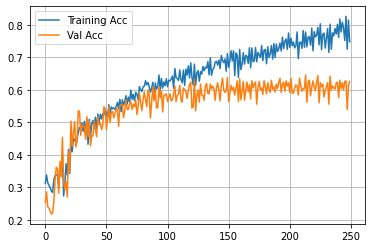

In [13]:
# plot training vs validation accuracy
plt.plot(trainer.train_acc_history, label='Training Acc')
plt.plot(trainer.val_acc_history, label='Val Acc')
plt.legend(loc='best')
plt.grid()
plt.show()


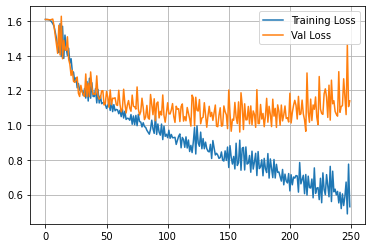

In [14]:
#plot training vs validation loss
plt.plot(trainer.loss_history, label='Training Loss')
plt.plot(trainer.loss_history_val, label='Val Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [15]:
correct = cp.sum(model.fit(X_test)==Y_test)
acc = correct/500#clear_output()
print("Overall average Test accuracy: %d/500 = %f" % ( correct, acc))

for i in range(5):
    correct = cp.sum(model.fit(X_test[i*100:(i+1)*100])==Y_test[i*100:(i+1)*100])
    acc = correct/100
    #clear_output()
    print("Average Test accuracy for class %s: %d/100 = %f" % (classes[int(cp.asnumpy(Y_test[i*100+1]))], correct, acc))


Overall average Test accuracy: 355/500 = 0.710000
Average Test accuracy for class sunflowers: 96/100 = 0.960000
Average Test accuracy for class tulips: 63/100 = 0.630000
Average Test accuracy for class daisy: 78/100 = 0.780000
Average Test accuracy for class dandelion: 71/100 = 0.710000
Average Test accuracy for class roses: 47/100 = 0.470000


In [16]:
model.save()

# Load the best results model
Loads the data from the previously trained model and fit the data using it

In [17]:
prefix='best/'       #the path to the model
best_lr = 0.001
best_reg = 0
model_best = Network(network = [
            ConvLayer2D(filter_size=(3,3,3), filters_num=16, lr=best_lr, reg=best_reg, opt='adam' ), 
            ReLU(),
            MaxPoolLayer(pool_size=(2,2)), 
            ConvLayer2D(filter_size=(3,3,16), filters_num=32, lr=best_lr, reg=best_reg, opt='adam' ),
            ReLU(),
            MaxPoolLayer(pool_size=(2,2)), 
            ConvLayer2D(filter_size=(3,3,32), filters_num=64, lr=best_lr, reg=best_reg, opt='adam' ), 
            ReLU(),
            MaxPoolLayer(pool_size=(2,2)), 
            FlattenLayer(),
            Dense(4*4*64, 1024, lr=best_lr, reg=best_reg, prefix=prefix, opt='adam'),
            leakyReLU(),
            Dropout(0.5),
            Dense(1024, 512, lr=best_lr, reg=best_reg, prefix=prefix, opt='adam'),
            leakyReLU(),
            Dropout(0.5),
            Dense(512, 5, lr=best_lr, reg=best_reg, prefix=prefix, opt='adam')
        ])
model_best.load()  #load the weights of each layer


In [18]:
#calculate the accuracy overall
correct = cp.sum(model_best.fit(X_test)==Y_test) 
acc = correct/500#clear_output()
print("Overall average Test accuracy: %d/500 = %f" % ( correct, acc))

#Calculate per class accuracy
for i in range(5):
    correct = cp.sum(model_best.fit(X_test[i*100:(i+1)*100])==Y_test[i*100:(i+1)*100])
    acc = correct/100
    #clear_output()
    print("Average Test accuracy for class %s: %d/100 = %f" % (classes[int(cp.asnumpy(Y_test[i*100+1]))], correct, acc))

Overall average Test accuracy: 355/500 = 0.710000
Average Test accuracy for class sunflowers: 96/100 = 0.960000
Average Test accuracy for class tulips: 63/100 = 0.630000
Average Test accuracy for class daisy: 78/100 = 0.780000
Average Test accuracy for class dandelion: 71/100 = 0.710000
Average Test accuracy for class roses: 47/100 = 0.470000
